# 计算shuttling所需电压
1. 按照lukeqi文章所说的最小二乘损失函数，计算离子在特定位置需要的电压
2. 带入华为要求的离子坐标随时间变化的关系，计算电压随时间关系
3. 结合dac的具体设置，将电压信息生成为表格

In [1]:
from potential_initialization import *
from trap_model import *
%load_ext autoreload
%autoreload 2
# 缓存pseudo potential在一个字典中，若在调试时修改了trap_model的定义可以快速初始化
pbi= dict()

In [2]:
# 设置需要计算势场的区域
shuttle_range = [[-1, 1], [-0.1, 0.1], [0.08, 0.2]]
stepsize = 0.01
# rf电压和频率需要提前设置
V_rf = 160
omega_rf = 2 * np.pi * 16e6
# 初始化trap_model类型
bowtie = trap_model("bowtie_ie5", V_rf, omega_rf, shuttle_range, stepsize, pbi, regenerate=False)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [3]:
# 在x=0.4时rf零点的坐标，
rf_null = bowtie.rf_null_point(x=0.4)
# 初始化 电极配对、dc接地电极偏置 情况下的电极分组情况
base_gc = bowtie.base_gc(paired=True, ground_bias=True, max_v=10, only_negative=False)
# 找到距离目标点最近的三对电极（以及dc接地电极）
gc = bowtie.top_nearest(rf_null, 11, base_gc)
# 将离子束缚在该位置需要如何设置电压
voltage = bowtie.optimize_voltage(x0=0.4, gc=gc, t_type='point', w=[0, 100, 1, 100, 1000, 0.001, 0.001, 0, 0.0005, 0, 0, 0], )

  0%|          | 0/50 [00:00<?, ?it/s]

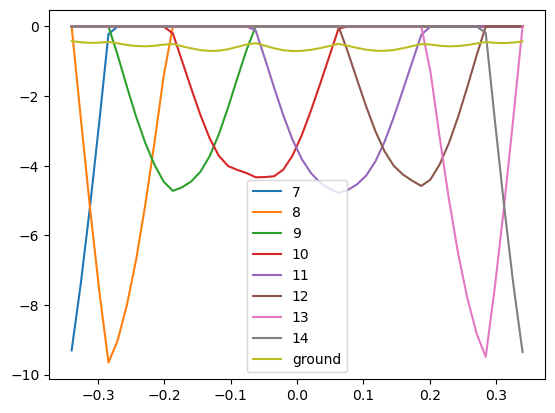

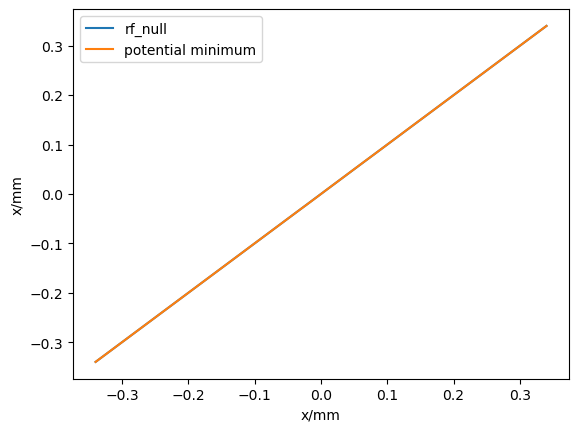

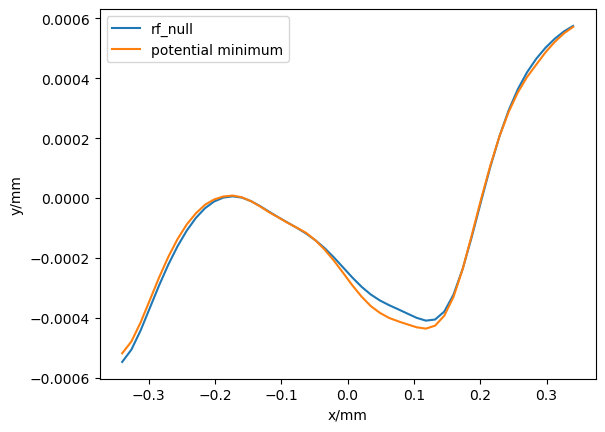

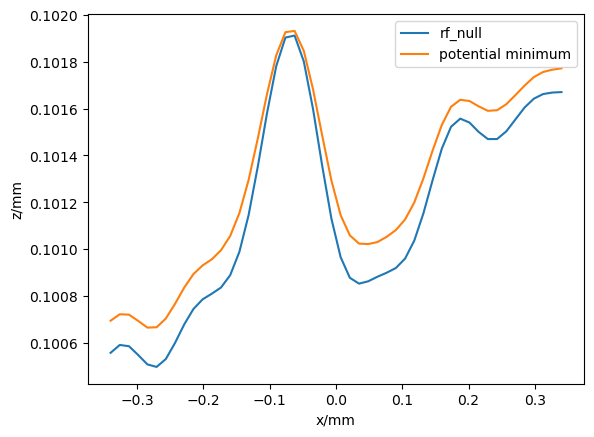

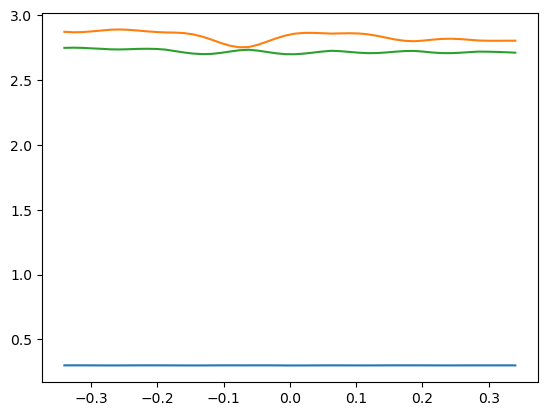

In [8]:
# junction.reset_rf(V_rf=170, omega_rf=omega_rf)
# 输运的方向沿x方向，由x=-0.34到x=0.34
x_initial = -0.34
x_final = 0.34
N_seg = 50
profile = np.linspace(x_initial, x_final, N_seg)
volts = bowtie.optimize_voltage_profile(profile, plot=True, top_nearest=5, max_v=10, omega=[0.3,3,3]
                                        , w=[0, 1000, 1, 10, 1000, 0.001, 0.001, 0, 0.005, 0, 0, 0], alpha=5000, ground_bias=True)

C:\Users\TangGaoxiang\AppData\Local\Temp\ipykernel_19988\1020651186.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([d])], ignore_index=True)


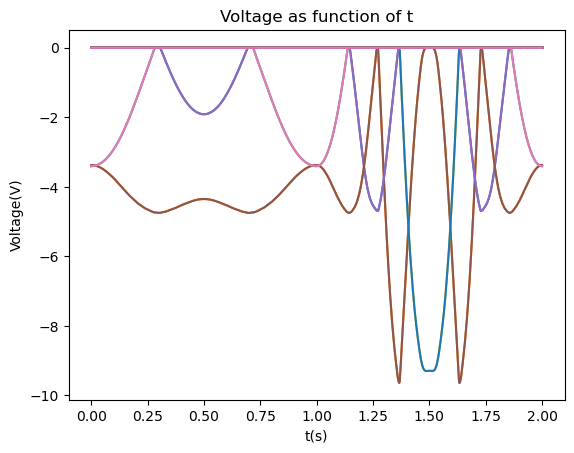

In [14]:
# 将电压随时间变化关系翻译成dac能够接收的形式

import pandas as pd

def export_waveform(T, V, name):
    clms = ["T"] + ["L"+str(i) for i in range(1, 25)] + ["R"+str(i) for i in range(1, 25)]
    df = pd.DataFrame(columns=clms)
    for t, v in zip(T, V):
        d = {"T":t}
        for i, idx in enumerate([42, 41, 40, 39, 38, 7, 11, 6, 37, 36]):
            d["L"+str(10-i)]=v[idx]
        for i, idx in enumerate([28, 27, 26, 25, 24, 3, 9, 2, 23, 22]):
            d["L"+str(i+15)]=v[idx]
        d["L12"]=v[14]
        d["L13"]=v[13]
        for i, idx in enumerate([35, 34, 5, 10, 4, 33, 32, 31, 30, 29]):
            d["R"+str(i+1)] = v[idx]
        d["R12"]=160
        for i, idx in enumerate([21, 20, 1, 8, 0, 19, 18, 17, 16, 15]):
            d["R"+str(24-i)] = v[idx]
        # df.append(d, ignore_index=True)
        df = pd.concat([df, pd.DataFrame([d])], ignore_index=True)
    df.to_excel("waveforms/"+name+".xlsx")


# 定义离子预期位置随时间变化的关系
T = 2
def x_of_t(t):
    if t<1:
        return 0.05*(1-np.cos(np.pi*2*t))
    if t<2:
        return 0.17*(1-np.cos(np.pi*2*t))
    return 0

tspan=np.linspace(0, T, 2000)

v_of_x = ndsplines.make_interp_spline(profile, volts)
v_of_t = lambda t: v_of_x(x_of_t(t))

plt.plot(tspan, [v_of_t(t) for t  in tspan])
plt.xlabel("t(s)")
plt.ylabel("Voltage(V)")
plt.title("Voltage as function of t")


# 将电压信息输出
export_waveform(tspan, V=[v_of_t(t) for t  in tspan], name="shuttle_demo")

Text(0.5, 1.0, 'x as function of t')

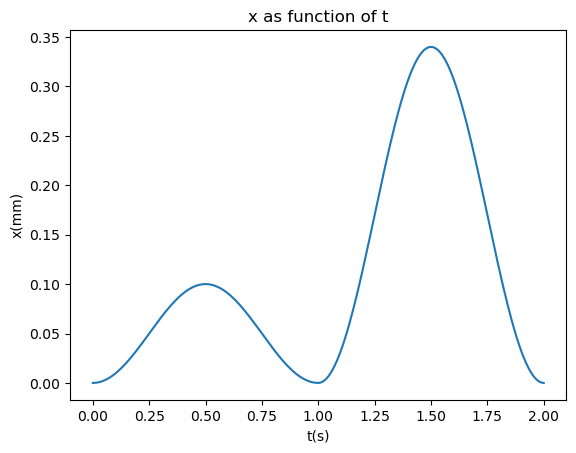

In [13]:
plt.plot(tspan, [x_of_t(t) for t  in tspan])
plt.xlabel("t(s)")
plt.ylabel("x(mm)")
plt.title("x as function of t")

# 计算STA加热率

In [4]:
from shuttle_protocols import qsin, const_speed, qsta2, qsta
T = 1e-4

tspan=np.linspace(0, T, N_seg)

v_of_t = lambda t: ndsplines.make_interp_spline(profile, volts)(t) if t < T else volts[-1]
V = [v_of_t(t) for t in tspan]

export_waveform(tspan, V, "shuttle")

C:\Users\TangGaoxiang\AppData\Local\Temp\ipykernel_19988\676396677.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([d])], ignore_index=True)


In [10]:

q0_of_t, tspan, y = bowtie.transport_motion(T, x_initial, x_final, volts, N_ions=1, protocol=qsta, freq=3e5)

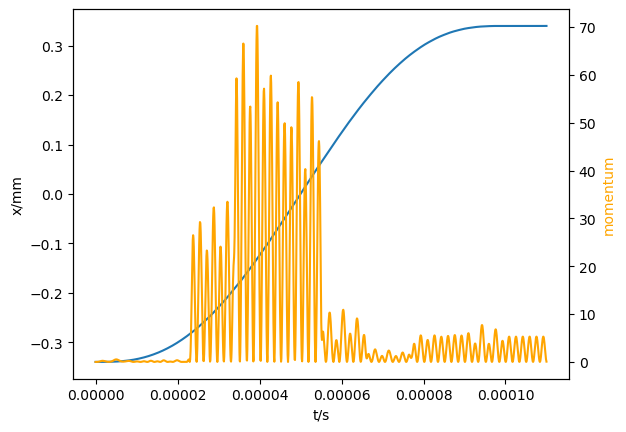

In [11]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()


ax1.plot(tspan, y[0])
ax1.set_xlabel("t/s")
ax1.set_ylabel("x/mm")
heating = bowtie.heating_one_ion_during_transportation(q0_of_t, tspan, y.transpose(), ax=ax2)

8.813637107877753

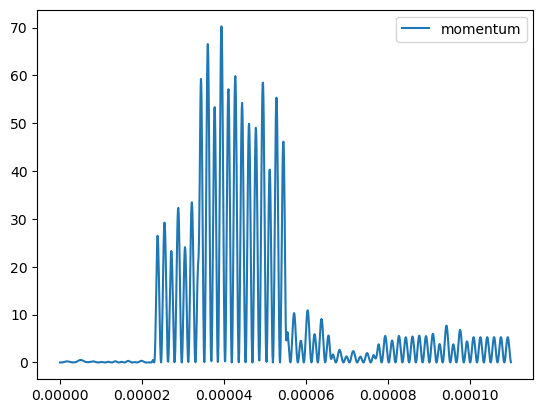

In [13]:
heating = bowtie.heating_one_ion_during_transportation(q0_of_t, tspan, y.transpose())
heating = bowtie.heating_one_ion(tspan, T, y[0], 0.3e6*2*np.pi)
heating

In [25]:
volts.shape

(200, 47)

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
cnt = 0
ax = ax.reshape(ax.size)
for i, opt in enumerate(volts):
    if i % 20 == 0:

        bowtie.plot_slice(opt, z=0.1, ax=ax[cnt])
        ax[cnt].set_title('x=%.3f' % profile[i])
        # ax[cnt].set_xlabel("x")
        ax[cnt].plot([profile[i], profile[i]],[-0.1,0.1], lw=1, c="r")
        cnt += 1